In [38]:
import requests
import pandas as pd
import seaborn as sns

In [54]:
url = 'https://stooq.pl/q/d/l/?s=cpiypl.m&i=m'
response = requests.get(url)
open('cpim.pl.csv','wb').write(response.content)

cpipl = pd.read_csv('cpim.pl.csv')

cpipl.set_index('Data',inplace=True)
cpipl = cpipl['2002-01-31':'2023-03-31']


<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

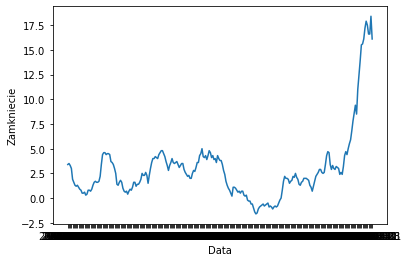

In [55]:
sns.lineplot(data=cpipl['Zamkniecie'])